Inspired/based on https://github.com/rayidghani/magicloops and https://github.com/dssg/MLforPublicPolicy/blob/master/labs/2019/lab6_feature_generation_sol.ipynb

In [290]:
import pipeline_v2 as pipeline
import importlib
import datetime
import pandas as pd
import numpy as np

# Read data

In [291]:
importlib.reload(pipeline)

datafile = "projects_2012_2013.csv"
data = pd.read_csv(datafile, parse_dates=['date_posted', 'datefullyfunded'])

# Explore data

Data exploration...

Number of rows: 124976

Columns and types of data:
projectid                                         object
teacher_acctid                                    object
schoolid                                          object
school_ncesid                                    float64
school_latitude                                  float64
school_longitude                                 float64
school_city                                       object
school_state                                      object
school_metro                                      object
school_district                                   object
school_county                                     object
school_charter                                    object
school_magnet                                     object
teacher_prefix                                    object
primary_focus_subject                             object
primary_focus_area                                object
secondary_focus_

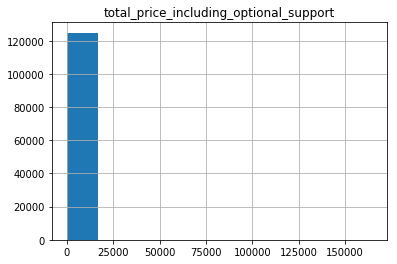

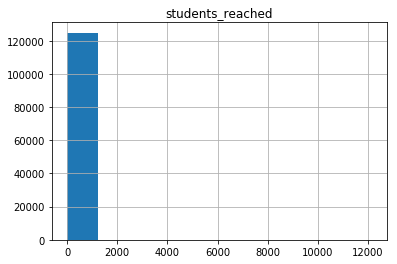

In [292]:
importlib.reload(pipeline)

stats_for_variables = [
  'total_price_including_optional_support',
  'students_reached'
]

variables_for_correlation = [
  'total_price_including_optional_support',
  'students_reached'
]

pipeline.explore_data(data, stats_for_variables, variables_for_correlation)

We can clearly see in the histograms that total_price_including_optional_support and students_reached have very big outliers.

# Create outcome label

In [293]:
importlib.reload(pipeline)

# The task is to predict if a project will not get fully funded within 60 days of posting.
data['duration_of_funding'] = data.datefullyfunded - data.date_posted
data['not_funded_in_60'] =  np.where(data['duration_of_funding']<=pd.Timedelta('60 days'), 1, 0)
output_label ='not_funded_in_60'

# Create temporal train and test sets

In [294]:
importlib.reload(pipeline)
from dateutil.relativedelta import relativedelta

#Create three sets of train and test data, based on threee different split thresholds
#The split thresholds corresponds to the starting date of the testing data
split_thresholds = [pd.Timestamp(2013,7,1), pd.Timestamp(2013,1,1), pd.Timestamp(2012,7,1)]

#Indicating which is the column to be used for splitting training and test daata
date_column='date_posted'

#Amount of data used for test set
test_window = relativedelta(months=6)

#Gap needed between training and test set. 60 days in this case
gap_training_test = relativedelta(days=100)

#Generate train and test sets
train_test_sets= pipeline.create_temp_validation_train_and_testing_sets(
  data,
  date_column,
  output_label,
  split_thresholds,
  test_window,
  gap_training_test)

# Process data

In [295]:
importlib.reload(pipeline)

#Impute data on continuous columns for each training and test set
#Continuous float variables that are meaningful for this problem.
float_columns = ['total_price_including_optional_support', 'students_reached']

for train_test_set in train_test_sets:
    pipeline.fill_na_columns_with_mean(train_test_set['x_train'], float_columns)
    pipeline.fill_na_columns_with_mean(train_test_set['x_test'], float_columns)


# Create features

In [316]:
'''
Selected features:
-All categorical(str_columns) columns that have less than 50 unique values, we will convert them to binary values (ex: school_metro, poverty_level)
-Continuous float variables that are informative to this problem (total_price_including_optional_support, students_reached)
-We will also discretize float variables that have significant outliers (more than 6 std from mean). These are exactly the two previous continues variables 
-We will keep both continuous and discrete values of these variables, since one informs the exact values which could be useful, and the other helps us manage outliers. We dont know which version will be initially more useful for the model so we will keep both.
-Continuous int variables for month and year of project date_posted
-Aggregation feature: amount of projects founded in the last 10 days
'''

importlib.reload(pipeline)

#We will have to generate features independently for each different train/test set
for train_test_set in train_test_sets:
    
    x_train_data = train_test_set['x_train']
    x_test_data = train_test_set['x_test']

    #1.Generate dummy features for categorical data
    train_features, test_features = pipeline.create_dummys_for_categorical_data(x_train_data,x_test_data)
    
    #2.Generate discrete features (then turn them to binaries)
    train_features, test_features = pipeline.create_discrete_features(x_train_data, x_test_data, train_features, test_features, float_columns)
    
    #3.Include continuous float variables as features
    for float_column in float_columns:
        train_features[float_column]=x_train_data[float_column]
        test_features[float_column]=x_test_data[float_column]
 
    #4.Include month and year of date posted as feature
    train_features, test_features = pipeline.create_month_year_features(x_train_data, x_test_data, train_features, test_features)
    
    #5. Aggregate feature: number of projects that got funded in the last 10 days. Idea: if many projects have been funded lately, this could be good info to predictor if a project will be funded soon
    train_features, test_features = pipeline.create_feature_number_of_projects_funded_in_last_10_days(data,x_train_data, x_test_data, train_features, test_features)

    
    #Replace values in train_test_set with all features generated
    train_test_set['x_train'] = train_features
    train_test_set['x_test'] = test_features


# Build Clasifiers and parameters generation

In [317]:
importlib.reload(pipeline)

#We define the specific models we want to run
#In the meantime not running BA because it takes a long time
#According to what sploken with Rayid, not running SVM, KNN, NB. Althoguh available in pipeline
models_to_run=['DT','LR','RF','ET','AB','GB']#,'BA', 'SVM','KNN','NB']

#Get all posible models and their different sets of parameters
models, parameters_grid = pipeline.get_models_and_parameters()


# Loop over models and different training/test sets

In [318]:
importlib.reload(pipeline)
import warnings

warnings.filterwarnings('ignore')

results = pipeline.iterate_over_models_and_training_test_sets(models_to_run, models, parameters_grid, train_test_sets)
results

,model_name,model,parameters,test_set_start_date,baseline,p_at_1,r_at_1,f1_at_1,p_at_2,r_at_2,...,p_at_20,r_at_20,f1_at_20,p_at_30,r_at_30,f1_at_30,p_at_50,r_at_50,f1_at_50,auc-roc
0,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",2013-07-01,0.736791,1.000000,0.013524,0.026687,1.000000,0.027117,...,0.738631,0.200499,0.315388,0.825754,0.336223,0.477871,0.895350,0.607601,0.723930,0.592321
1,LR,"LogisticRegression(C=0.01, class_weight=None, ...","{'penalty': 'l1', 'C': 0.01}",2013-07-01,0.736791,0.958974,0.012969,0.025592,0.956522,0.025938,...,0.901891,0.244816,0.385098,0.875319,0.356405,0.506555,0.827389,0.561481,0.668980,0.657027
2,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'n_estimators': 1, 'max_depth': 1, 'max_featu...",2013-07-01,0.736791,0.964103,0.013038,0.025729,0.982097,0.026632,...,0.998212,0.270962,0.426226,0.998808,0.406686,0.578019,0.999182,0.678064,0.807883,0.500049
3,ET,"(ExtraTreeClassifier(class_weight=None, criter...","{'criterion': 'gini', 'n_estimators': 1, 'max_...",2013-07-01,0.736791,1.000000,0.013524,0.026687,1.000000,0.027117,...,0.670158,0.181913,0.286151,0.780106,0.317636,0.451454,0.867961,0.589014,0.701785,0.524903
4,AB,"(DecisionTreeClassifier(class_weight=None, cri...","{'n_estimators': 1, 'algorithm': 'SAMME'}",2013-07-01,0.736791,1.000000,0.013524,0.026687,1.000000,0.027117,...,0.738631,0.200499,0.315388,0.825754,0.336223,0.477871,0.895350,0.607601,0.723930,0.592321
5,GB,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.1, 'n_estimators': 1, 'max...",2013-07-01,0.736791,1.000000,0.013524,0.026687,1.000000,0.027117,...,0.814768,0.221167,0.347897,0.876512,0.356890,0.507245,0.925805,0.628268,0.748554,0.586328
6,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",2013-01-01,0.704587,1.000000,0.014136,0.027877,1.000000,0.028271,...,0.668190,0.189599,0.295383,0.778861,0.331604,0.465163,0.867142,0.615355,0.719866,0.608703
7,LR,"LogisticRegression(C=0.01, class_weight=None, ...","{'penalty': 'l1', 'C': 0.01}",2013-01-01,0.704587,0.972477,0.013747,0.027110,0.972477,0.027493,...,0.888483,0.252107,0.392767,0.868108,0.369602,0.518465,0.812683,0.576709,0.674657,0.681364
8,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'n_estimators': 1, 'max_depth': 1, 'max_featu...",2013-01-01,0.704587,1.000000,0.014136,0.027877,1.000000,0.028271,...,0.572212,0.162365,0.252955,0.557112,0.237194,0.332727,0.734101,0.520944,0.609421,0.531843
9,ET,"(ExtraTreeClassifier(class_weight=None, criter...","{'criterion': 'gini', 'n_estimators': 1, 'max_...",2013-01-01,0.704587,1.000000,0.014136,0.027877,1.000000,0.028271,...,1.000000,0.283750,0.442065,1.000000,0.425755,0.597235,1.000000,0.709636,0.830160,0.526039


<Figure size 432x288 with 0 Axes>

# Observe best models for each train/test set

## Ranking by Precision at 5%

In [319]:
#Lets obtain the best model for each train/test set

#indices of rows that have max precision at 5% for each train/test set
idx = results.groupby(['test_set_start_date'])['p_at_5'].transform(max) == results['p_at_5']

#display best models
best_p_at_5 = results[idx].iloc[:, [0,1,2,3,4,11,12,13,26]]
best_p_at_5

,model_name,model,parameters,test_set_start_date,baseline,p_at_5,r_at_5,f1_at_5,auc-roc
0,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",2013-07-01,0.736791,1.0,0.067827,0.127038,0.592321
3,ET,"(ExtraTreeClassifier(class_weight=None, criter...","{'criterion': 'gini', 'n_estimators': 1, 'max_...",2013-07-01,0.736791,1.0,0.067827,0.127038,0.524903
4,AB,"(DecisionTreeClassifier(class_weight=None, cri...","{'n_estimators': 1, 'algorithm': 'SAMME'}",2013-07-01,0.736791,1.0,0.067827,0.127038,0.592321
5,GB,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.1, 'n_estimators': 1, 'max...",2013-07-01,0.736791,1.0,0.067827,0.127038,0.586328
6,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",2013-01-01,0.704587,1.0,0.070938,0.132478,0.608703
9,ET,"(ExtraTreeClassifier(class_weight=None, criter...","{'criterion': 'gini', 'n_estimators': 1, 'max_...",2013-01-01,0.704587,1.0,0.070938,0.132478,0.526039
10,AB,"(DecisionTreeClassifier(class_weight=None, cri...","{'n_estimators': 1, 'algorithm': 'SAMME'}",2013-01-01,0.704587,1.0,0.070938,0.132478,0.608703
11,GB,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.1, 'n_estimators': 1, 'max...",2013-01-01,0.704587,1.0,0.070938,0.132478,0.605680
12,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",2012-07-01,0.742604,1.0,0.067256,0.126036,0.606802
15,ET,"(ExtraTreeClassifier(class_weight=None, criter...","{'criterion': 'gini', 'n_estimators': 1, 'max_...",2012-07-01,0.742604,1.0,0.067256,0.126036,0.503961


## Ranking by AUC

In [320]:
#indices of rows that have max auc for each train/test set
idx = results.groupby(['test_set_start_date'])['auc-roc'].transform(max) == results['auc-roc']

#display best models
best_auc = results[idx]
best_auc

,model_name,model,parameters,test_set_start_date,baseline,p_at_1,r_at_1,f1_at_1,p_at_2,r_at_2,...,p_at_20,r_at_20,f1_at_20,p_at_30,r_at_30,f1_at_30,p_at_50,r_at_50,f1_at_50,auc-roc
1,LR,"LogisticRegression(C=0.01, class_weight=None, ...","{'penalty': 'l1', 'C': 0.01}",2013-07-01,0.736791,0.958974,0.012969,0.025592,0.956522,0.025938,...,0.901891,0.244816,0.385098,0.875319,0.356405,0.506555,0.827389,0.561481,0.668980,0.657027
7,LR,"LogisticRegression(C=0.01, class_weight=None, ...","{'penalty': 'l1', 'C': 0.01}",2013-01-01,0.704587,0.972477,0.013747,0.027110,0.972477,0.027493,...,0.888483,0.252107,0.392767,0.868108,0.369602,0.518465,0.812683,0.576709,0.674657,0.681364
13,LR,"LogisticRegression(C=0.01, class_weight=None, ...","{'penalty': 'l1', 'C': 0.01}",2012-07-01,0.742604,0.925926,0.012418,0.024507,0.933579,0.025134,...,0.865363,0.233062,0.367222,0.826119,0.333698,0.475375,0.813634,0.547785,0.654753,0.624604


# Compare all models performance at different train/test sets

In [321]:
#For each model, find the set of parameters that work the best in each train/test set

#In this dataframe we will save the best model for each type of model (ex 1 LR, 1 RF..), whichever perfomed the best in each train/test set
best_models= pd.DataFrame()

for model in models_to_run:
  #Filter data selecting only rows of this specific modelpd.to_numeric(
  results_of_model = results[results["model_name"]==model]  
  #For each train/test set, find index of best model (parameters)
  idx = results_of_model.groupby(['test_set_start_date'])['auc-roc'].transform(max) == results_of_model['auc-roc']
    
  #Grab those results based on index
  best_model = results_of_model[idx]
  #Append it to final list
  best_models=best_models.append(best_model)

<Figure size 432x288 with 0 Axes>

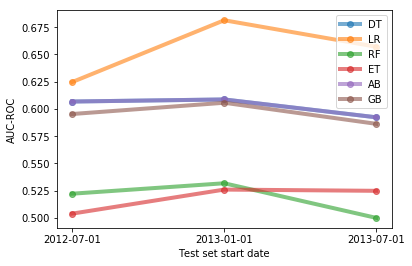

In [322]:
import matplotlib.pyplot as plt

#Clear plot
plt.clf()

#Create plot and axis
fig, ax1 = plt.subplots()

#Create lines for each model
for model in models_to_run:
  ax1.plot( 'test_set_start_date', 'auc-roc', data=best_models[best_models['model_name']==model], label=model, marker='o', markersize=6, linewidth=4,alpha=0.6)

#Show legends
plt.legend()

#Set axis labels
ax1.set_xlabel('Test set start date')
ax1.set_ylabel('AUC-ROC',)

#Invert x_axis so as to show from earliest to latest
ax1.invert_xaxis()

plt.show()